C:\Users\ayush\AppData\Local\Temp\ipykernel_3716\3259690430.py:100: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  width_deviation.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)


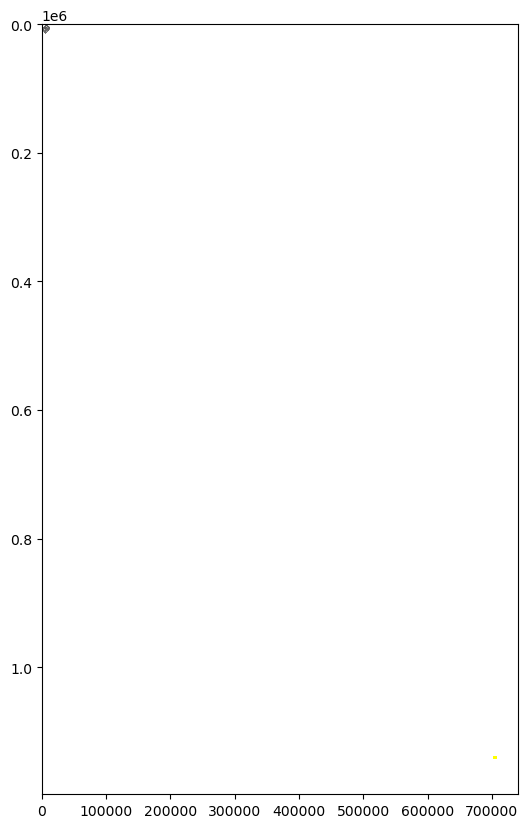

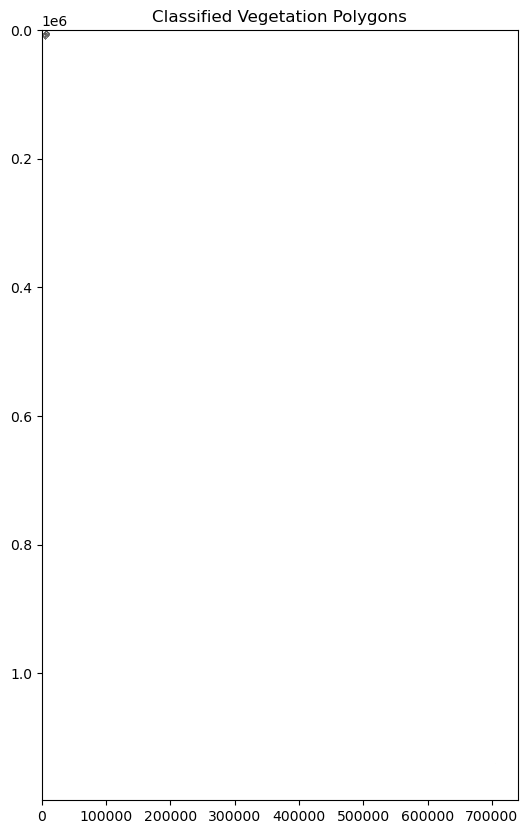

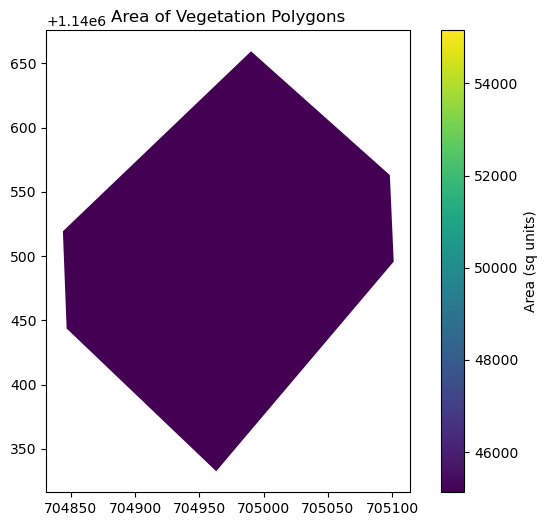

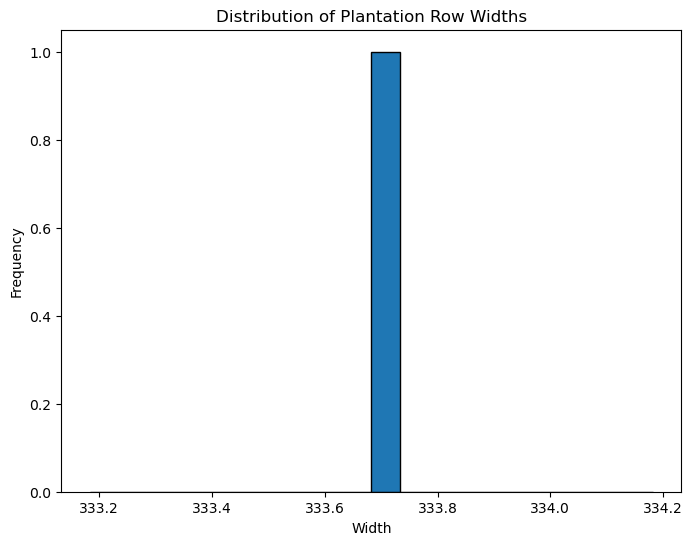

In [19]:
# Import necessary libraries
import rasterio
import geopandas as gpd
from shapely.geometry import shape
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import unary_union

# Define paths to input data
ortho_path = 'D:\downl\SURINOVA_CBE_ORTHO.tif'
dtm_path = 'D:\downl\SURINOVA_CBE_DTM.tif'
dsm_path = 'D:\downl\SURINOVA_CBE_DSM.tif'

# Threshold for vegetation classification
threshold = 2  # Adjust as needed

# Function to classify vegetation
import rasterio
from rasterio.enums import Resampling

# Function to classify vegetation
def classify_vegetation(ortho_path, dtm_path, dsm_path):
    # Load orthomosaic and DSM
    with rasterio.open(ortho_path) as src:
        ortho = src.read(1)
        crs = src.crs
    
    with rasterio.open(dsm_path) as src:
        dsm = src.read(1)
        dsm_transform = src.transform
        dsm_crs = src.crs
    
    with rasterio.open(dtm_path) as src:
        dtm = src.read(1)
        dtm_transform = src.transform
        dtm_crs = src.crs
    
    # Ensure DSM and DTM have the same spatial extent and resolution
    if dsm_transform != dtm_transform:
        # Resample DTM to match the resolution of DSM
        dtm = np.empty_like(dsm)
        rasterio.warp.reproject(
            source=dtm,
            destination=dtm,
            src_transform=dtm_transform,
            src_crs=dtm_crs,
            dst_transform=dsm_transform,
            dst_crs=dsm_crs,
            resampling=Resampling.nearest)
    
    # Calculate canopy height model (CHM)
    chm = dsm - dtm

    # Threshold CHM to classify vegetation
    vegetation = np.where(chm > threshold, 1, 0)
    
    # Convert vegetation raster to vector
    shapes = rasterio.features.shapes(vegetation, transform=dsm_transform)
    polygons = [shape(s).buffer(0) for s, _ in shapes if _ == 1]
    
    # Convert polygons to GeoDataFrame
    gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)
    
    return gdf

# Function to calculate area of each polygon
def calculate_area(gdf):
    gdf['area'] = gdf.area
    return gdf

# Function to analyze width of plantation rows
def calculate_width(row_polygon):
    mbr = row_polygon.minimum_rotated_rectangle
    width = mbr.bounds[2] - mbr.bounds[0]  # Assuming the MBR is aligned with the x-axis
    
    return width

# Function to analyze width of plantation rows
def analyze_width(gdf):
    # Calculate width of each polygon (assuming they represent rows)
    gdf['width'] = gdf['geometry'].apply(calculate_width)
    
    # Calculate the median width of all rows
    median_width = gdf['width'].median()
    
    # Identify regions where width significantly deviates from the median
    gdf['deviation'] = gdf['width'] > 1.2 * median_width
    
    return gdf

# Function to create navigation map
def create_navigation_map(ortho, gdf, width_analysis_results):
    # Assuming you have a base map, here we'll just visualize the vegetation polygons
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(ortho, cmap='gray')
    gdf.plot(ax=ax, facecolor='none', edgecolor='red')
    
    # Plotting regions with significant width deviation
    width_deviation = gdf[width_analysis_results['deviation']]
    width_deviation.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
    
    # Highlighting critical areas where width exceeds 1.2 meters
    critical_areas = gdf[gdf['width'] > 1.2]
    critical_areas.plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=2)
    
    plt.show()

# Main function
# Main function
def main():
    # Classify vegetation
    vegetation_gdf = classify_vegetation(ortho_path, dtm_path, dsm_path)
    
    # Calculate area of each polygon
    vegetation_gdf = calculate_area(vegetation_gdf)
    
    # Analyze width of plantation rows
    width_analysis_results = analyze_width(vegetation_gdf)
    
    # Load orthomosaic
    with rasterio.open(ortho_path) as src:
        ortho = src.read(1)
    
    # Create navigation map
    create_navigation_map(ortho, vegetation_gdf, width_analysis_results)
    
    # Plot classified vegetation polygons
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(ortho, cmap='gray')
    vegetation_gdf.plot(ax=ax, facecolor='green', edgecolor='none', alpha=0.5)
    ax.set_title('Classified Vegetation Polygons')
    plt.show()
    
    # Plot areas of vegetation polygons
    fig, ax = plt.subplots(figsize=(8, 6))
    vegetation_gdf.plot(ax=ax, column='area', legend=True, legend_kwds={'label': "Area (sq units)"})
    ax.set_title('Area of Vegetation Polygons')
    plt.show()
    
    # Plot widths of plantation rows
    fig, ax = plt.subplots(figsize=(8, 6))
    width_analysis_results['width'].plot(kind='hist', bins=20, edgecolor='black', ax=ax)
    ax.set_title('Distribution of Plantation Row Widths')
    ax.set_xlabel('Width')
    ax.set_ylabel('Frequency')
    plt.show()

# Call the main function
if __name__ == "__main__":
    main()


